# 1 |THE DATASET
    

- In this dataset we have **6 different sentiments**, which means we'll be treating this problem as a multiclass classification problem

In [ ]:
!ls /kaggle/input/emotion-dataset/

ls: cannot access '/kaggle/input/emotion-dataset/': No such file or directory


In [ ]:
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20), #first 20
                    show_index=False, #don't show index
                    pagination='local', #pagination will be done on client side
                         page_size=10) #each page will have 10 values


pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

validation = pd.read_csv('/content/validation.csv')
train = pd.read_csv('/content/training.csv')
test = pd.read_csv('/content/test.csv')

print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {validation.shape}')
print(f'Test data: {test.shape}')

Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [ ]:
show_panel(train)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### Combine DataFrames into Dataset

In [ ]:
!pip install datasets

from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Don't forget the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets
emotions = DatasetDict({
    "train": Dataset.from_pandas(train,features=ft),
    "test": Dataset.from_pandas(test,features=ft),
    "validation": Dataset.from_pandas(validation,features=ft)
    })

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Selecting a Subset
- We'll be working with the **training and validation dataset** in this problem


In [ ]:
# Training Data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### Dataset to DataFrame Convertion

In [ ]:
# Convert Dataset to DataFrame (don't forget to reset)
emotions.set_format(type="pandas")
df = emotions["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

### Adding Label Data
- We can convert **numeric** values to **string** values by using method `int2str`

In [ ]:
# Add label data to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# CLASS DISTRIBUTION

- Our dataset has 6 classes `joy`, `sadness`, `anger`, `fear`, `love` and `surprise`; multiclass problem

In [ ]:
import plotly.express as px

px.bar(df['label_name'].value_counts(ascending=True),template='plotly_dark')

# LENGTH OF EACH TWEET

- For applications using **DistilBERT**, the maximum context size is **512 tokens**


In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

px.box(df,y='Words Per Tweet',
       color='label_name',
       template='plotly_dark')

In [ ]:
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# TOKENISATION

- As with other models,DistilBERT cannot receive raw python strings as input


### Character tokenisation  



In [ ]:
text = 'Tokenisation of text is a core task of NLP.'
tokenised_text = list(text)

# Character Tokenised list
print(f'Number of tokens: {len(tokenised_text)}')
print(tokenised_text)

Number of tokens: 43
['T', 'o', 'k', 'e', 'n', 'i', 's', 'a', 't', 'i', 'o', 'n', ' ', 'o', 'f', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


- Convert each character into an integer (numericalisation)
- `token2idx` gives us a mapping from each character in the **vocabulary** to a unique integer

In [ ]:
# Mapping Vecabulary dictionary
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenised_text)))}

print(f'Length of vocabulary: {len(token2idx)}')
print(token2idx)

Length of vocabulary: 18
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17}


### Reconstructing text


In [ ]:
# Let's represent text in numerical format
input_ids = [token2idx[token] for token in tokenised_text]

print(f'{len(input_ids)} characters')
print(input_ids)

43 characters
[5, 13, 11, 8, 12, 10, 15, 6, 16, 10, 13, 12, 0, 13, 9, 0, 16, 8, 17, 16, 0, 10, 15, 0, 6, 0, 7, 13, 14, 8, 0, 16, 6, 15, 11, 0, 13, 9, 0, 3, 2, 4, 1]


### Convert to OHE



In [ ]:
import torch
import torch.nn.functional as F

inputs_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(inputs_ids,num_classes = len(token2idx))
print(f'OHE size: {one_hot_encodings.shape}')

OHE size: torch.Size([43, 18])


### Word tokenisation  



In [ ]:
tokenised_text = text.split()
print(tokenised_text)

['Tokenisation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword tokenisation





In [ ]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Show tokeniser information
tokenizer

# Or we can load the Tokeniser manually `transformers.DistilBertTokenizer`

# from transformers import DistilBertTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
# distilbert_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 30522
Max length: 512
Tokeniser model input names: ['input_ids', 'attention_mask']


In [ ]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text
{'input_ids': [101, 19204, 6648, 1997, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

Tokens
['[CLS]', 'token', '##isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]'] 

Convert tokens to string
[CLS] tokenisation of text is a core task of nlp. [SEP] 



In [ ]:
emotions.reset_format()

### Tokenising the entire dataset

- When dealing with text of different size, the tokeniser will pad sentences of insufficient length if padding is selected
- The maximum length of the tokenised data will be the length of the longest tweet (in example, 2nd row)


In [ ]:
# Tokenisation function
def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Show the tokenised ids
ex_tokenised = tokenise(emotions["train"][:2])

In [ ]:
# Show attention mask
ex_tokenised['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [ ]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


# TRAINING A TEXT CLASSIFIER



### Transformers as feature extractors(using pretrained model)

In [ ]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extracting the last hidden state (example)


In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


### Extracting the last hidden state for the Dataset



In [ ]:
def extract_hidden_states(batch):

    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating the Feature Matrix


In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (16000, 768)
Validation Dataset (2000, 768)


In [ ]:
# Let's check our dataset
X_train

array([[-0.1167513 ,  0.09857138, -0.12962897, ...,  0.0587108 ,
         0.35432693,  0.4042067 ],
       [-0.03236292, -0.03231524, -0.19572599, ..., -0.17465737,
         0.35463768,  0.30276582],
       [ 0.03974647,  0.2022336 ,  0.14227113, ..., -0.11406833,
         0.33937776,  0.395831  ],
       ...,
       [-0.00339847, -0.09585506,  0.05843544, ..., -0.04272703,
         0.2495916 ,  0.30761623],
       [ 0.06660261,  0.17334324,  0.12896673, ...,  0.06118569,
         0.29038215,  0.46844164],
       [ 0.01668789,  0.10127088, -0.00731721, ..., -0.06493651,
         0.34540522,  0.21993564]], dtype=float32)

### Visualising the Training Data



In [ ]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_train

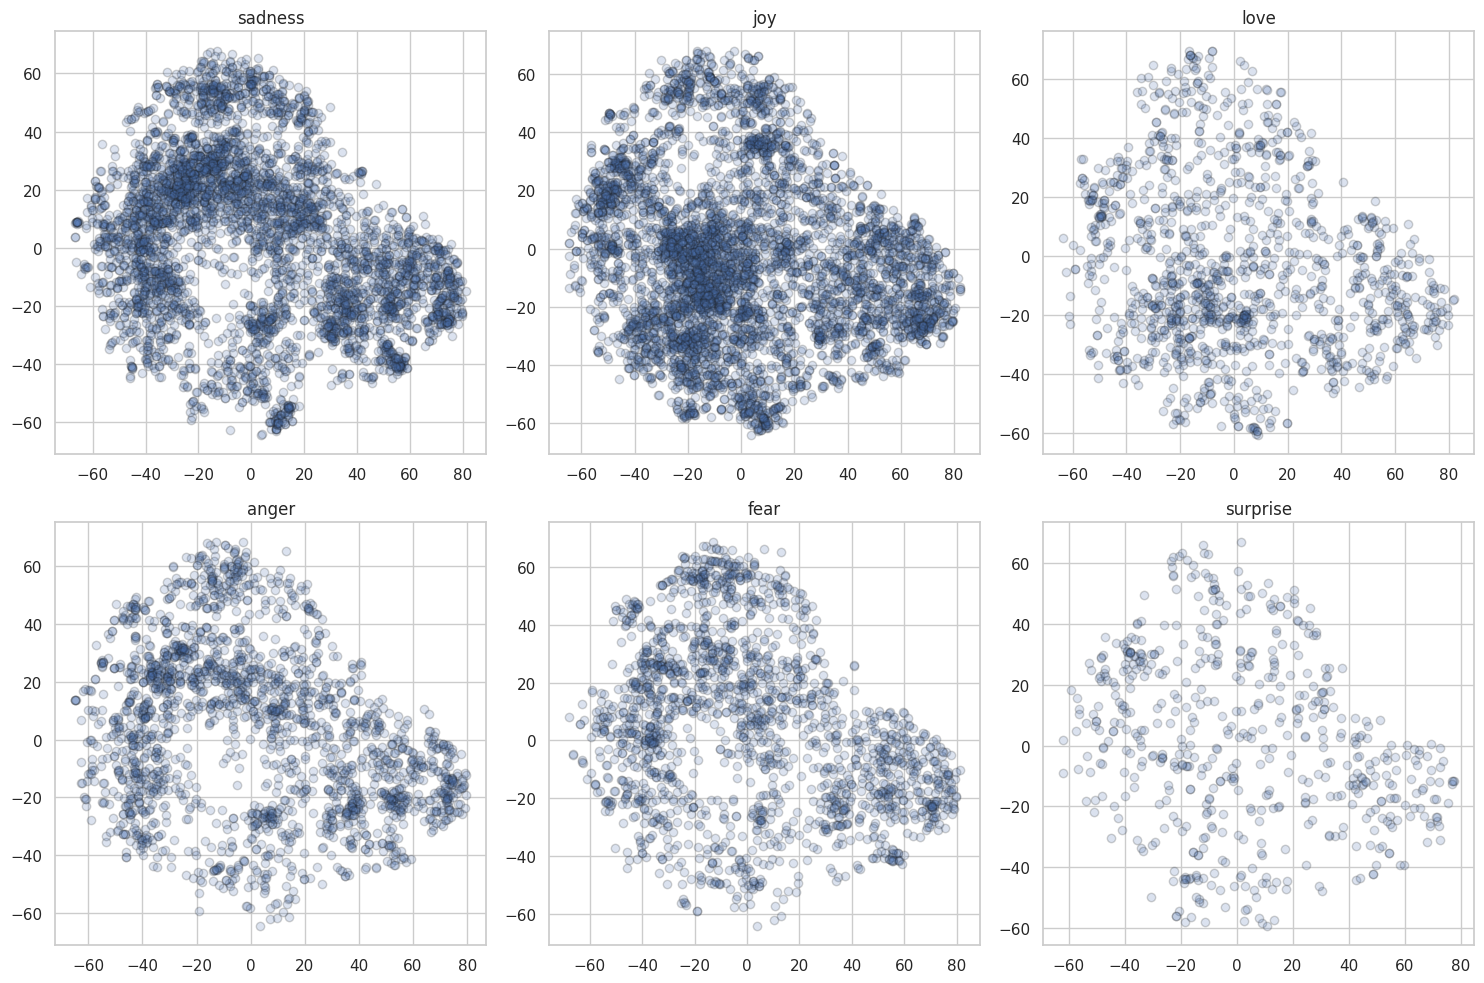

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
labels = emotions["train"].features["label"].names

for i, label in enumerate(labels):

    dict_embedding_sub = dict(tuple(df_embedding.groupby('label')))
    df_embedding_sub = dict_embedding_sub[i]

    axes[i].scatter(df_embedding_sub["X"],
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.2)

    axes[i].set_title(f'{label}')

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns:
- For positive emotions joy and love are well separated from the negative emotions and also share a similar space
- Negative emotions sadness,anger, and fear all occupy very similar regions with slightly varying distributions in lower dimension space


### Training a Baseline Model

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'accuracy: {dummy_clf.score(X_valid, y_valid)}')

accuracy: 0.352


In [ ]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.6335


### Confusion Matrix



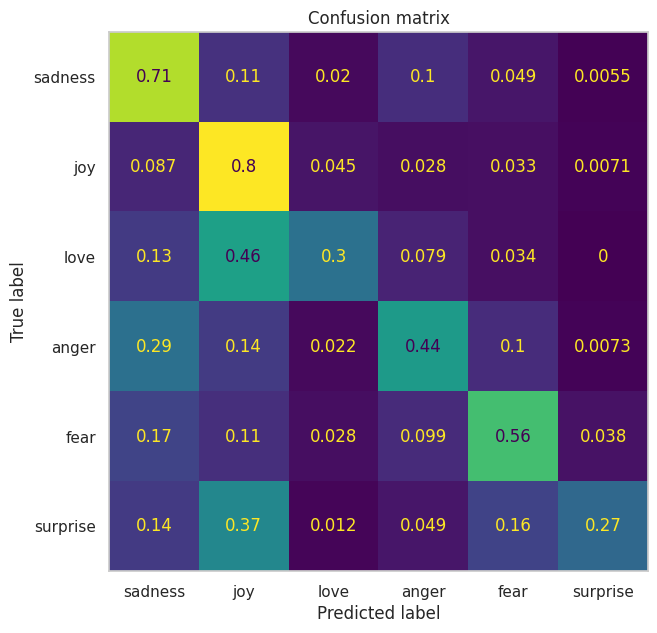

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

From the confusion matrix we can say that:

- anger, fear & surprise often confused with sadness (0.29, 0.17 & 0.14) (observation we made when visualising the embeddings)
- love & surprise are frequently mistaken for joy (0.37 & 0.46)

### Fine-tuning transformers



In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt,
                          num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the Performance Metrics
- We'll monitor the `F1 score`  & `accuracy`, the function is required to be passed in the `Trainer` class



In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training parameters


In [ ]:
!pip install accelerate

from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

### Train Model


In [ ]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818100,0.285891,0.915500,0.915610
2,0.216500,0.192059,0.926000,0.926238
3,0.148200,0.171342,0.932500,0.932686


TrainOutput(global_step=750, training_loss=0.39423719787597655, metrics={'train_runtime': 354.018, 'train_samples_per_second': 135.586, 'train_steps_per_second': 2.119, 'total_flos': 1080514292544000.0, 'train_loss': 0.39423719787597655, 'epoch': 3.0})

In [ ]:
# Predict on Validation Dataset
pred_output = trainer.predict(emotions_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[ 5.150027  , -0.84036326, -1.2421685 , -1.007606  , -1.2835778 ,
        -1.8294055 ],
       [ 5.191213  , -1.0247822 , -1.9038932 , -0.644091  , -1.1892267 ,
        -1.8892152 ],
       [-1.4144325 ,  2.4703786 ,  3.3464522 , -0.96862274, -1.886256  ,
        -1.8237025 ],
       ...,
       [-1.4661208 ,  5.1569858 , -0.16341639, -1.1373297 , -2.0824952 ,
        -1.4162594 ],
       [-1.631388  ,  3.2755356 ,  2.965176  , -1.2967107 , -1.8919102 ,
        -1.8986511 ],
       [-1.4988742 ,  4.970184  , -0.5065004 , -1.5264904 , -2.069048  ,
        -0.37075126]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.17134182155132294, 'test_accuracy': 0.9325, 'test_f1': 0.9326857335571515, 'test_runtime': 4.1643, 'test_samples_per_second': 480.277, 'test_steps_per_second': 7.684})

In [ ]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (2000, 6)
[[ 5.150027   -0.84036326 -1.2421685  -1.007606   -1.2835778  -1.8294055 ]
 [ 5.191213   -1.0247822  -1.9038932  -0.644091   -1.1892267  -1.8892152 ]
 [-1.4144325   2.4703786   3.3464522  -0.96862274 -1.886256   -1.8237025 ]
 ...
 [-1.4661208   5.1569858  -0.16341639 -1.1373297  -2.0824952  -1.4162594 ]
 [-1.631388    3.2755356   2.965176   -1.2967107  -1.8919102  -1.8986511 ]
 [-1.4988742   4.970184   -0.5065004  -1.5264904  -2.069048   -0.37075126]]


In [ ]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions,axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(2000,)
Predictions: [0 0 2 ... 1 1 1]


In [ ]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.17134182155132294,
 'test_accuracy': 0.9325,
 'test_f1': 0.9326857335571515,
 'test_runtime': 4.1643,
 'test_samples_per_second': 480.277,
 'test_steps_per_second': 7.684}

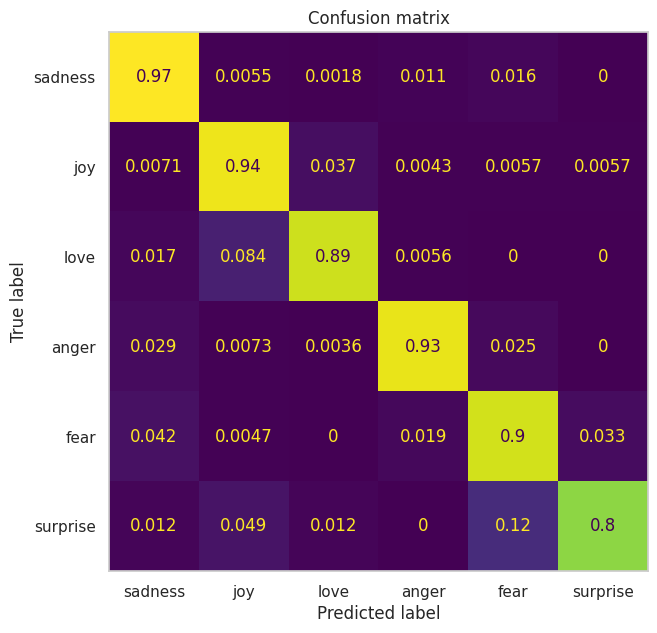

In [ ]:
plot_confusion_matrix(y_preds,y_valid,labels)

From the confusion matrix we can say that:
- The fine-tune approach DistilBERT performs much better than simple extracting embedding data and training it on a separate ML model
- love is still often confused with joy (0.08), but much less than the first approach
- surprise is often confused with joy  as well (0.09) or fear (0.10), both also much less than the first approach

# MODEL ERROR ANALYSIS



In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    print(inputs)
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'input_ids': tensor([[  101, 10047,  3110,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2001,  ...,     0,     0,     0],
        [  101,  1045,  2939,  ...,     0,     0,     0],
        [  101,  1045,  2196,  ...,     0,     0,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}
{'input_ids': tensor([[ 101, 1045, 2134,  ...,    0,    0,    0],
        [ 101, 1045, 2113,  ...,    0,    0,    0],
        [ 101, 1045, 2036,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2736,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0]], device='cuda

### Convert to DataFrame

- Create a DataFrame with the text, losses, predicted/true labels

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

- Now we can sort `emotions` encoded by the losses in either assending/descending order
- Let's look at the data samples with the **highest losses** (we can see that high loss values are associated with misspredictions)

In [ ]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [ ]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

# USING OUR MODEL

In [ ]:
# Save the model
trainer.save_model()

In [ ]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

- Our model predicts `new_data` to be classified to **label 1** (**joy**)

In [ ]:
preds = classifier(new_data, return_all_scores=True)
preds

[[{'label': 'LABEL_0', 'score': 0.002596151316538453},
  {'label': 'LABEL_1', 'score': 0.9830324649810791},
  {'label': 'LABEL_2', 'score': 0.0029011238366365433},
  {'label': 'LABEL_3', 'score': 0.003381522372364998},
  {'label': 'LABEL_4', 'score': 0.0013836263678967953},
  {'label': 'LABEL_5', 'score': 0.006705129984766245}]]

In [ ]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.002596151316538453},
 {'label': 'LABEL_1', 'score': 0.9830324649810791},
 {'label': 'LABEL_2', 'score': 0.0029011238366365433},
 {'label': 'LABEL_3', 'score': 0.003381522372364998},
 {'label': 'LABEL_4', 'score': 0.0013836263678967953},
 {'label': 'LABEL_5', 'score': 0.006705129984766245}]

In [ ]:
df_preds = pd.DataFrame(preds)
#print(df_preds)

#scores = df_preds.apply(lambda x: x['score'])
scores = df_preds.apply(lambda x: x[0]['score'])

#print(scores)
px.bar(x=labels,y=100*scores,template='plotly_white')